Ли-Зан-Мен Сергей MLOps-22

Этот ноутбук чистая версия, только реализация модели (юзал гугл, после кучи сообщений, что лаба изи и скоры меньше 1%), обучал в коллабе, чтобы решить проблему с CTCloss (и быстрее)

In [ ]:
import os

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchinfo import summary
from torchmetrics.functional import char_error_rate

from PIL import Image

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
RANDOM_STATE = 2
TRAIN_SIZE = 0.8
DATA_PATH = './drive/MyDrive/samples'

TRAIN_BATCH_SIZE = 128

SIZE_W = 200
SIZE_H = 50

LABEL_LENGTH = 5 

In [ ]:
device = 'cpu'

# проверить, доступна ли у вас CUDA. 
if torch.cuda.is_available():
    device = 'cuda'
    
try: # на mps не считается CTCloss
    if torch.backends.mps.is_available():
        device = 'mps'
except Exception:
    pass

print('Device:', device)

Device: cuda


# 1.Подготовка данных. 
1. Реализовал класс датасет для данных
2. Считываю изображения как gray-scale, тк они все ч/б
3. Для нормализации изображений сперва считаю статистики по всему датасету, чтоыб закрепить их
4. Делю на трейн/тест

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_names = [
            file_name for file_name in  os.listdir(img_dir) 
            if file_name.endswith('.png') or file_name.endswith('.jpg')
        ]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('L') # To gray-scale
        label = self.img_names[idx].split('.')[0]  
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Get mean and std
transform_compose =transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0], std=[1])
])

full_dataset = ImageDataset(DATA_PATH, transform=transform_compose) # Return normalized tensor (C, H, W)

full_loader = DataLoader(full_dataset, batch_size=len(full_dataset))

images, labels = next(iter(full_loader)) # Images (B, C, H, W) = (1070, 1, 50, 200)

all_symbols = sorted(set(''.join(labels))) # Get id for each symbol from dataset

symbol2id = dict(zip(all_symbols, range(1, len(all_symbols) + 1)))
id2symbol = {v: k for k, v in symbol2id.items()}

print('Symbol for id:', symbol2id)
print('Id for symbol:', id2symbol)

# Get mean and std by (batch, width, height)
mean_images = images.mean([0, 2, 3])
std_images = images.std([0, 2, 3])
print('\nMean:', mean_images)
print('Std:', std_images)


Symbol for id: {'2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}
Id for symbol: {1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}

Mean: tensor([182.3633])
Std: tensor([80.0027])


In [ ]:
def label_to_tensor(label_str: str) -> torch.Tensor:
    v = torch.zeros(LABEL_LENGTH)
    for i, sym in enumerate(label_str):
        v[i] = symbol2id[sym]
    return v

In [ ]:
# Fixing constants 
IMAGE_MEAN = 182.3633
IMAGE_STD = 80.0027

assert np.isclose(IMAGE_MEAN, mean_images) 
assert np.isclose(IMAGE_STD, std_images) 

transform_compose =transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[IMAGE_MEAN], std=[IMAGE_STD])
])

full_dataset = ImageDataset(DATA_PATH, transform=transform_compose, target_transform=label_to_tensor)

torch.manual_seed(RANDOM_STATE)

train_size = int(TRAIN_SIZE * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

print(f'Full shape: {len(full_dataset)}')
print(f'Train shape: {len(train_dataset)}')
print(f'Test shape: {len(test_dataset)}')

Full shape: 1070
Train shape: 856
Test shape: 214


In [ ]:
test_dataset[0][0].shape

torch.Size([1, 50, 200])

# 2.Создание и обучение модели
1. Модель из описания лабы
2. Пробовал несколько лстм слоев, но увеличение сверток сработало лучше


In [ ]:
def conv_block_3x3(in_channels, out_channels, stride=1, padding=1, max_pool=(2, 2)):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, (3, 3), stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, (3, 3), stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(max_pool),
    )


class OCRModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.cn = nn.Sequential(
            conv_block_3x3(1, 64),
            conv_block_3x3(64, 128),
            conv_block_3x3(128, 256),
            conv_block_3x3(256, 256, max_pool=1),
        )

        self.hidden_size = 256
        self.num_layers = 2
        self.d = 2

        self.lstm = nn.LSTM(
            input_size = 1536,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            bidirectional = True,
            dropout = 0.25,
            batch_first=True
        )
        self.output = nn.Linear(self.hidden_size * 2, len(symbol2id) + 1) # blank already added

    def forward(self, x, h=None, c=None):
        x = self.cn(x)
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W) -> (B, W, C, W) 
        x = x.view(x.size(0), x.size(1), -1) # (B, C, H, W) -> (B, C, H * W)
        # print(x.shape)

        h = torch.rand(self.d * self.num_layers, x.size(0), self.hidden_size, requires_grad=True).to(device)  # (D * num_layers, B, H out)
        c = torch.rand(self.d * self.num_layers, x.size(0), self.hidden_size, requires_grad=True).to(device)  # (D * num_layers, B, H cell)       
        
        x, (h, c) = self.lstm(x, (h, c)) 
        x = self.output(x)

        x = x.permute(1, 0, 2) # (B, W, N sym) -> (W, B, N sym) 
        return x


In [ ]:
m = OCRModel()
summary(m, (TRAIN_BATCH_SIZE, 1, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
OCRModel                                 [25, 128, 20]             --
├─Sequential: 1-1                        [128, 256, 6, 25]         --
│    └─Sequential: 2-1                   [128, 64, 25, 100]        --
│    │    └─Conv2d: 3-1                  [128, 64, 50, 200]        640
│    │    └─BatchNorm2d: 3-2             [128, 64, 50, 200]        128
│    │    └─ReLU: 3-3                    [128, 64, 50, 200]        --
│    │    └─Conv2d: 3-4                  [128, 64, 50, 200]        36,928
│    │    └─BatchNorm2d: 3-5             [128, 64, 50, 200]        128
│    │    └─ReLU: 3-6                    [128, 64, 50, 200]        --
│    │    └─Conv2d: 3-7                  [128, 64, 50, 200]        36,928
│    │    └─BatchNorm2d: 3-8             [128, 64, 50, 200]        128
│    │    └─ReLU: 3-9                    [128, 64, 50, 200]        --
│    │    └─MaxPool2d: 3-10              [128, 64, 25, 100]        --
│  

In [ ]:
model = OCRModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CTCLoss(blank=0, zero_infinity=True, reduction='mean')


history_loss = []

In [ ]:
def compute_ctc_loss(text_batch_logits, text_batch):
    '''
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    '''
    text_batch_logits = text_batch_logits
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes] 

    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), fill_value=text_batch_logps.size(2), dtype=torch.int32)
                                       

    text_batch_targets_lens = torch.full(size=(labels.size(0),), fill_value=LABEL_LENGTH, dtype=torch.int32)
    # print(text_batch_logits.shape)
    # print(text_batch_logps.shape)
    # print(text_batch_logps_lens.shape)
    # print(text_batch_targets_lens.shape)
    loss = loss_func(text_batch_logps, text_batch, text_batch_logps_lens, text_batch_targets_lens)
    return loss

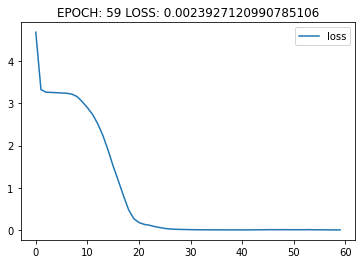

loss=0.0021457578986883163:  14%|█▍        | 1/7 [00:01<00:10,  1.76s/it]


KeyboardInterrupt: ignored

In [ ]:
torch.manual_seed(RANDOM_STATE)

N_EPOCH = 150

model.train()
for i_ep in range(len(history_loss), len(history_loss) + N_EPOCH):
    epoch_loss = []

    t = tqdm(train_loader)
    for data in t:
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients for every batch
        opt.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = compute_ctc_loss(outputs, labels)

        epoch_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Adjust learning weights
        opt.step()
        t.set_description(f'loss={loss.item()}')

    epoch_loss = np.mean(epoch_loss)

    # Plot train loss
    history_loss.append(epoch_loss)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    clear_output(True)
    ax.plot(history_loss, label='loss')
    ax.legend()
    ax.set_title(f'EPOCH: {i_ep} LOSS: {epoch_loss}')
    plt.show()


# 3.Подсчет метрик. 
1. Восстанавливаю ответ удалением дублей, делю по '_' (но теперь бланк берется из СТСлосса) и беру первую часть при делении по '$'
2. Test CЕR: 0.005607476457953453

In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ''
    return ''.join(letters)


def correct_prediction(word):
    print(word)
    parts = word.split('_')
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = ''.join(parts)
    return corrected_word


def decode_predictions(preds):
    preds = preds.permute(1, 0, 2) # (B, T, Classes)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    cap_preds = []
    for i_ts in range(preds.shape[0]):
        temp = []
        for i_sym in preds[i_ts]:
            if i_sym == 0:
              sym = '_'
            else:
              sym = id2symbol[i_sym.item()]
            temp.append(sym)
        cap_preds.append(correct_prediction(''.join(temp)))
    return cap_preds


def get_label_from_ids(label_ids):
    labels = []
    for i_batch in range(label_ids.size(0)):
        label = ''
        for i_sym in label_ids[i_batch]:
            if i_sym == 0:
              label += '_'
            label += id2symbol[i_sym.item()]
        labels.append(label)
    return labels


def get_character_error_rate(logits, label_ids):
    """
    Get Character Error
    """
    labels = get_label_from_ids(label_ids)[0]
    preds = decode_predictions(outputs)[0][:-1]
    return labels, preds, char_error_rate(preds, labels)


In [ ]:
torch.manual_seed(RANDOM_STATE)

model.eval()
# total_cer_test = 0
bad_predict = []
good_predict = []
all_labels = []
all_pred_labels = []
t = tqdm(range(len(test_dataset)))
for i in t:
    # Every data instance is an input + label pair
    inputs, labels = test_dataset[i]
    inputs, labels = inputs.to(device), labels.to(device)
    inputs, labels = inputs.unsqueeze(0), labels.unsqueeze(0)
    with torch.no_grad():
        outputs = model(inputs)

    label, pred_label, cer = get_character_error_rate(outputs, labels)
    print(f'{label=} {pred_label=} {cer}')
    all_labels.append(label)
    all_pred_labels.append(pred_label)

    t.set_description(f'cer={cer.item()}')
    # total_cer_test += cer
    if cer > 0.1:
        bad_predict.append((cer, i, pred_label))
    else:
        good_predict.append((cer, i, pred_label))

# total_cer_test /= len(test_dataset) * (LABEL_LENGTH - 1)
total_cer_test = char_error_rate(all_pred_labels, all_labels)
print('Test CER:', total_cer_test.item())

cer=0.0:   6%|▌         | 13/214 [00:00<00:03, 61.90it/s]

m__ww__5__p_22________b__
label='mw5p2' pred_label='mw5p2' 0.0
n__8__f_pp_6__________b__
label='n8fp6' pred_label='n8fp6' 0.0
e__ff_g__x_55_________b__
label='efgx5' pred_label='efgx5' 0.0
p__b__p__g__c_________f__
label='pbpgc' pred_label='pbpgc' 0.0
p__y__e__f__b_________f__
label='pyefb' pred_label='pyefb' 0.0
x__4__4__n_44_________f__
label='x44n4' pred_label='x44n4' 0.0
m__6__n__4_xx_________b__
label='m6n4x' pred_label='m6n4x' 0.0
n__x__f_22_c__________b__
label='nxf2c' pred_label='nxf2c' 0.0
x__m__cc_y_mm_________b__
label='xmcym' pred_label='xmcym' 0.0
g__n__2_dd_3__________b__
label='gn2d3' pred_label='gn2d3' 0.0
cc_6__7_4__5__________b__
label='c6745' pred_label='c6745' 0.0
7__w__yy_p__4_________b__
label='7wyp4' pred_label='7wyp4' 0.0
3__3_b__2_22__________f__
label='33b22' pred_label='33b22' 0.0


cer=0.0:   9%|▉         | 20/214 [00:00<00:03, 62.27it/s]                

n__d__m__e_7__________f__
label='ndme7' pred_label='ndme7' 0.0
x__3__f_ww__ff________f__
label='x3fwf' pred_label='x3fwf' 0.0
6__m___e__g__e________b__
label='6mege' pred_label='6mege' 0.0
d__e__f_yy_x__________b__
label='defyx' pred_label='defyx' 0.0
y__55_w__2__8_________b__
label='y5w28' pred_label='y5w28' 0.0
p__ww__n__5__e________f__
label='pwn5e' pred_label='pwn5e' 0.0
d__7__n__n_3__________f__
label='d7nn3' pred_label='d7nn3' 0.0
g__w__n__m___6________f__
label='gwnm6' pred_label='gwnm6' 0.0
x__b__c__b__x_________b__
label='xbcbx' pred_label='xbcbx' 0.0
n__2_g__m__g__________b__
label='n2gmg' pred_label='n2gmg' 0.0
6__7__8__w__33________f__
label='678w3' pred_label='678w3' 0.0
e__4__6_yy_ww_________f__
label='e46yw' pred_label='e46yw' 0.0
d__g__m___d__8________f__
label='dnmd8' pred_label='dgmd8' 0.20000000298023224
8__n__4__n_8__________f__
label='8n4n8' pred_label='8n4n8' 0.0


cer=0.0:  16%|█▋        | 35/214 [00:00<00:02, 68.53it/s]

b__5__p_n__n__________b__
label='b5pnn' pred_label='b5pnn' 0.0
ff_ww__x__d__p________f__
label='fwxdp' pred_label='fwxdp' 0.0
ff_c_6__x__b__________f__
label='fc6xb' pred_label='fc6xb' 0.0
x__4__5__8_ww_________b__
label='x458w' pred_label='x458w' 0.0
b__f_55_2__c__________b__
label='bf52c' pred_label='bf52c' 0.0
n__5__w__5__g_________f__
label='n5w5g' pred_label='n5w5g' 0.0
2__n__x_3__8__________f__
label='2nx38' pred_label='2nx38' 0.0
p__x__8__n__8_________b__
label='px8n8' pred_label='px8n8' 0.0
x__yy_yy_y__ww________f__
label='xyyyw' pred_label='xyyyw' 0.0
c__d__6__p_4__________f__
label='cd6p4' pred_label='cd6p4' 0.0
cc_3__5_3_ee__________b__
label='c353e' pred_label='c353e' 0.0
ff_cc_n_e__6__________b__
label='fcne6' pred_label='fcne6' 0.0
3__p__6__7_n__________b__
label='3p67n' pred_label='3p67n' 0.0
cc_4__5_2__7__________f__
label='c4527' pred_label='c4527' 0.0
6__n__g_66_w__________f__
label='6ng6w' pred_label='6ng6w' 0.0
b__3__5__f_6__________b__
label='b35f6' pred_label='b35

cer=0.0:  24%|██▍       | 51/214 [00:00<00:02, 68.81it/s]

e__d__g_33_p__________f__
label='edg3p' pred_label='edg3p' 0.0
p__ff_4__n_b__________f__
label='pf4nb' pred_label='pf4nb' 0.0
3__4__f_x__m__________f__
label='34fxm' pred_label='34fxm' 0.0
n__d__5_w___g_________f__
label='nd5wg' pred_label='nd5wg' 0.0
w___m___4_77_ff_______f__
label='wm47f' pred_label='wm47f' 0.0
n__ff_7_b__n__________f__
label='nf7bn' pred_label='nf7bn' 0.0
8__f_g__d__w__________f__
label='6fgdw' pred_label='8fgdw' 0.20000000298023224
2__4__5_yy_5__________f__
label='245y5' pred_label='245y5' 0.0
d__n__2_6__n__________f__
label='dn26n' pred_label='dn26n' 0.0
6__2__n_b__3__________b__
label='62nb3' pred_label='62nb3' 0.0
e__w__n__x__8_________b__
label='ewnx8' pred_label='ewnx8' 0.0
x__x__ww__4__4________f__
label='xxw44' pred_label='xxw44' 0.0
5__7_3__d_88__________f__
label='573d8' pred_label='573d8' 0.0
n__ff_2_n__8__________f__
label='nf2n8' pred_label='nf2n8' 0.0


cer=0.0:  31%|███       | 66/214 [00:01<00:02, 70.28it/s]

x__ff_g__6__5_________b__
label='xfg65' pred_label='xfg65' 0.0
4__3__m___n_55________b__
label='43mn5' pred_label='43mn5' 0.0
n__7__f__f_2__________f__
label='n7ff2' pred_label='n7ff2' 0.0
cc_8_66_m__d__________f__
label='c86md' pred_label='c86md' 0.0
b__2__6_nn_d__________b__
label='b26nd' pred_label='b26nd' 0.0
n__f_88_b__8__________b__
label='nf8b8' pred_label='nf8b8' 0.0
5__3_ww__b__8_________b__
label='53wb8' pred_label='53wb8' 0.0
7__8__e_ee_cc_________f__
label='78eec' pred_label='78eec' 0.0
e__7_n__x__4__________f__
label='e7nx4' pred_label='e7nx4' 0.0
3__3_n__7_3___________b__
label='33n73' pred_label='33n73' 0.0
b__e__3_b__p__________f__
label='be3bp' pred_label='be3bp' 0.0
ff_y_22_n__d__________f__
label='fy2nd' pred_label='fy2nd' 0.0
w__88_b__n__x_________f__
label='w8bnx' pred_label='w8bnx' 0.0
3__p_44_n__n__________b__
label='3p4nn' pred_label='3p4nn' 0.0
88_5__d__x_nn_________f__
label='85dxn' pred_label='85dxn' 0.0


cer=0.0:  39%|███▉      | 83/214 [00:01<00:01, 74.63it/s]

d__d__m___yy_g________b__
label='ddmyg' pred_label='ddmyg' 0.0
4__3__p_55_d__________f__
label='43p5d' pred_label='43p5d' 0.0
7__y__2_xx_4__________f__
label='7y2x4' pred_label='7y2x4' 0.0
n__3_b__m__6__________b__
label='n3bm6' pred_label='n3bm6' 0.0
n__g__6__y__p_________f__
label='ng6yp' pred_label='ng6yp' 0.0
x__ww__xx_77_d________f__
label='xwx7d' pred_label='xwx7d' 0.0
d__2__3_6__n__________f__
label='d236n' pred_label='d236n' 0.0
n__2_66_5__y__________b__
label='n265y' pred_label='n265y' 0.0
3__d__e_n__6__________b__
label='3den6' pred_label='3den6' 0.0
g__n__g__6_e__________b__
label='gng6e' pred_label='gng6e' 0.0
ff_w__33_b__2_________f__
label='fw3b2' pred_label='fw3b2' 0.0
2__4_3__m___m_________f__
label='243mm' pred_label='243mm' 0.0
3__n_d__x__d__________f__
label='3ndxd' pred_label='3ndxd' 0.0
y__g__e__7__c_________f__
label='yge7c' pred_label='yge7c' 0.0
b__n__c_2__f__________b__
label='bnc2f' pred_label='bnc2f' 0.0
6__7__7_g__3__________f__
label='677g3' pred_label='677

cer=0.0:  46%|████▋     | 99/214 [00:01<00:01, 76.47it/s]

ff_5__c_m___2_________f__
label='f5cm2' pred_label='f5cm2' 0.0
p__8__n__g_x__________b__
label='p8ngx' pred_label='p8ngx' 0.0
8__e__g__g__g_________b__
label='8eggg' pred_label='8eggg' 0.0
b__5__5_d__6__________f__
label='b55d6' pred_label='b55d6' 0.0
2__8__3_4__8__________b__
label='28348' pred_label='28348' 0.0
6__m___55_e__g________b__
label='6m5eg' pred_label='6m5eg' 0.0
m____c_3_5__n_________b__
label='mc35n' pred_label='mc35n' 0.0
5__f_3_gg_ff__________f__
label='5f3gf' pred_label='5f3gf' 0.0
7__d__g__c_2__________f__
label='7dgc2' pred_label='7dgc2' 0.0
3__n__w___7_ww________f__
label='3nw7w' pred_label='3nw7w' 0.0
y__55_n_66_d__________f__
label='y5n6d' pred_label='y5n6d' 0.0
8__7_d__4__cc_________f__
label='87d4c' pred_label='87d4c' 0.0
n__n__6_m__g__________b__
label='nn6mg' pred_label='nn6mg' 0.0
b__5__f_m__7__________b__
label='b5fm7' pred_label='b5fm7' 0.0
5__n_3__w___4_________f__
label='5n3w4' pred_label='5n3w4' 0.0


cer=0.0:  54%|█████▍    | 116/214 [00:01<00:01, 75.99it/s]

c__w___g__y_xx________f__
label='cwgyx' pred_label='cwgyx' 0.0
m__4__f_d__8__________f__
label='m4fd8' pred_label='m4fd8' 0.0
cc_5_5__c_6___________f__
label='c55c6' pred_label='c55c6' 0.0
88_n__e_44_g__________b__
label='8ne4g' pred_label='8ne4g' 0.0
b__g__d__4_m__________f__
label='bgd4m' pred_label='bgd4m' 0.0
4__2__x__p_yy_________f__
label='42xpy' pred_label='42xpy' 0.0
8__n__5_6__m__________f__
label='8n56m' pred_label='8n56m' 0.0
y__88_6__6__y_________f__
label='y866y' pred_label='y866y' 0.0
e__d__w___n__y________f__
label='edwny' pred_label='edwny' 0.0
c__d_44_ee_g__________f__
label='cd4eg' pred_label='cd4eg' 0.0
n__7__e_bb_xx_________b__
label='n7ebx' pred_label='n7ebx' 0.0
g__n__b__d__e_________b__
label='gnbde' pred_label='gnbde' 0.0
8__5__6_2__2__________f__
label='85622' pred_label='85622' 0.0
_f_f_n__x__n__________b__
label='ffnxn' pred_label='ffnxn' 0.0
e__2_55_x__g__________f__
label='e25xg' pred_label='e25xg' 0.0
p__m__g_55_5__________f__
label='pmg55' pred_label='pmg

cer=0.20000000298023224:  62%|██████▏   | 133/214 [00:01<00:01, 78.99it/s]

2__x__c__2_n__________f__
label='2xc2n' pred_label='2xc2n' 0.0
w___g_m__w__p_________f__
label='wgnwp' pred_label='wgmwp' 0.20000000298023224
3__7_88_e__5__________f__
label='378e5' pred_label='378e5' 0.0
4__yy_n__f_3__________f__
label='4ynf3' pred_label='4ynf3' 0.0
p__6__m___p__8________b__
label='p6mn8' pred_label='p6mp8' 0.20000000298023224
ff_c__2_f_ff__________f__
label='fc2ff' pred_label='fc2ff' 0.0
6__yy_d__y__p_________b__
label='6ydyp' pred_label='6ydyp' 0.0
6__p__ff_y_44_________f__
label='6pfy4' pred_label='6pfy4' 0.0
g__m__mm_n_ee_________f__
label='gmmne' pred_label='gmmne' 0.0
d__7__c_55_x__________f__
label='d7c5x' pred_label='d7c5x' 0.0
b__d__g__8_44_________f__
label='bdg84' pred_label='bdg84' 0.0
b__m__3__p_88_________f__
label='bm3p8' pred_label='bm3p8' 0.0
g__e__g__w__4_________b__
label='gegw4' pred_label='gegw4' 0.0
n__n__p_4__e__________b__
label='nnp4e' pred_label='nnp4e' 0.0
5__w__d__d__w_________f__
label='5wddw' pred_label='5wddw' 0.0
2__w___4__y_77________f

cer=0.0:  71%|███████   | 151/214 [00:02<00:00, 80.62it/s]

p__x__2__x__p_________f__
label='px2xp' pred_label='px2xp' 0.0
6__b__d__n_55_________f__
label='6bdn5' pred_label='6bdn5' 0.0
g__5__5_b__4__________f__
label='g55b4' pred_label='g55b4' 0.0
n__b__ff_x__5_________f__
label='nbfx5' pred_label='nbfx5' 0.0
d__n__2_yy_mm_________b__
label='dn2ym' pred_label='dn2ym' 0.0
m___33_5_88_8_________b__
label='m3588' pred_label='m3588' 0.0
y__7__m__n_mm_________f__
label='y7mnm' pred_label='y7mnm' 0.0
c__6_ww__e_6__________f__
label='c6we6' pred_label='c6we6' 0.0
n__6__x__c_5__________f__
label='n6xc5' pred_label='n6xc5' 0.0
cc_e__w__n__m_________b__
label='cewnm' pred_label='cewnm' 0.0
x__w__4__6__5_________f__
label='xw465' pred_label='xw465' 0.0
2__yy_g__g__g_________f__
label='2yggg' pred_label='2yggg' 0.0
6__f__g_88_cc_________f__
label='6fg8c' pred_label='6fg8c' 0.0
d__d__n__p__f_________f__
label='ddnpf' pred_label='ddnpf' 0.0
7__g__c_ee_6__________f__
label='7gce6' pred_label='7gce6' 0.0
n__g_44_66_m__________f__
label='ng46m' pred_label='ng4

cer=0.0:  79%|███████▉  | 169/214 [00:02<00:00, 80.33it/s]

5__x__d__2_e__________b__
label='5xd2e' pred_label='5xd2e' 0.0
p__2__x_77_x__________f__
label='p2x7x' pred_label='p2x7x' 0.0
5__n__p_4__m__________b__
label='5np4m' pred_label='5np4m' 0.0
d__b__e__x__3_________f__
label='dbex3' pred_label='dbex3' 0.0
d__p__b__y__d_________f__
label='dpbyd' pred_label='dpbyd' 0.0
n__g__7_5__6__________f__
label='ng756' pred_label='ng756' 0.0
b__yy_cc_8_22_________b__
label='byc82' pred_label='byc82' 0.0
e__e__8__f_g__________f__
label='ee8fg' pred_label='ee8fg' 0.0
b__c__w__n__n_________b__
label='bcwnn' pred_label='bcwnn' 0.0
6__ff_n__8_4__________f__
label='6fn84' pred_label='6fn84' 0.0
e__6__6__7_x__________f__
label='e667x' pred_label='e667x' 0.0
ff_g__3_88_b__________b__
label='fg38b' pred_label='fg38b' 0.0
7__w__6__7_m__________f__
label='7w67m' pred_label='7w67m' 0.0
2__5_ww_5__3__________b__
label='25w53' pred_label='25w53' 0.0
cc_p__c__8__c_________f__
label='cpc8c' pred_label='cpc8c' 0.0
8__b__b_ww__8_________b__
label='8bbw8' pred_label='8bb

cer=0.0:  87%|████████▋ | 186/214 [00:02<00:00, 77.25it/s]

7__6__n__x_nn_________b__
label='76nxn' pred_label='76nxn' 0.0
g__n__b__n_4__________f__
label='gnbn4' pred_label='gnbn4' 0.0
n__3__x_4__cc_________f__
label='n3x4c' pred_label='n3x4c' 0.0
d__n__n_e__7__________f__
label='dnne7' pred_label='dnne7' 0.0
b__g__b__4__8_________f__
label='bgb48' pred_label='bgb48' 0.0
x__xx_n__e__y_________b__
label='xxney' pred_label='xxney' 0.0
e__ww__yy_g__7________f__
label='ewyg7' pred_label='ewyg7' 0.0
p__d__y__cc_8_________b__
label='pdyc8' pred_label='pdyc8' 0.0
n__7_e__n__n__________b__
label='n7enn' pred_label='n7enn' 0.0
p__88_cc_2_4__________f__
label='p8c24' pred_label='p8c24' 0.0
5__n_xx_n__n__________f__
label='5nxnn' pred_label='5nxnn' 0.0
8__c__m_4__6__________f__
label='8cm46' pred_label='8cm46' 0.0
w___66_pp_xx_yy_______b__
label='w6pxy' pred_label='w6pxy' 0.0
2__6__8__g_2__________b__
label='268g2' pred_label='268g2' 0.0
b__m__x__p__e_________f__
label='bmxpe' pred_label='bmxpe' 0.0


cer=0.0:  91%|█████████ | 195/214 [00:02<00:00, 78.77it/s]

e__m___ww__p__n_______f__
label='emwpn' pred_label='emwpn' 0.0
ff_6_ww_ww___8________b__
label='f6ww8' pred_label='f6ww8' 0.0
b__2__8_g__8__________f__
label='b28g8' pred_label='b28g8' 0.0
ff_7__5_3__f__________f__
label='f753f' pred_label='f753f' 0.0
n__7_mm_e__b__________f__
label='n7meb' pred_label='n7meb' 0.0
y__e__m___yy_4________f__
label='yemy4' pred_label='yemy4' 0.0
ff_8__f_8__g__________b__
label='f8f8g' pred_label='f8f8g' 0.0
d__6__6__c_n__________f__
label='d66cn' pred_label='d66cn' 0.0
e__n__p_ww___2________b__
label='enpw2' pred_label='enpw2' 0.0
4__n__n_f__3__________b__
label='4nnf3' pred_label='4nnf3' 0.0
e__7__x_44_55_________f__
label='e7x45' pred_label='e7x45' 0.0
e__6__m__6_p__________f__
label='e6m6p' pred_label='e6m6p' 0.0
e__3__c__f_e__________b__
label='e3cfe' pred_label='e3cfe' 0.0
g__ff_b__x__6_________b__
label='gfbx6' pred_label='gfbx6' 0.0
x__n__n__c_3__________b__
label='xnnc3' pred_label='xnnc3' 0.0
6__m__n__8_n__________b__
label='6mn8n' pred_label='6mn

cer=0.0: 100%|██████████| 214/214 [00:02<00:00, 75.02it/s]


d__2__2__b_dd_________f__
label='d22bd' pred_label='d22bd' 0.0
5__p__m___6_b_________f__
label='5pm6b' pred_label='5pm6b' 0.0
x__n__n_44_d__________b__
label='xnn4d' pred_label='xnn4d' 0.0
n__2_b__y__7__________f__
label='n2by7' pred_label='n2by7' 0.0
5__6__m___6_yy________b__
label='56m6y' pred_label='56m6y' 0.0
3__n_22_b__4__________f__
label='3n2b4' pred_label='3n2b4' 0.0
5__n_g__g__g__________f__
label='5nggg' pred_label='5nggg' 0.0
4__e__ww__6__p________f__
label='yew6p' pred_label='4ew6p' 0.20000000298023224
w___e_cc_f_dd_________f__
label='wecfd' pred_label='wecfd' 0.0
b__g__x__c_dd_________f__
label='bgxcd' pred_label='bgxcd' 0.0
3__d__7_b__d__________f__
label='3d7bd' pred_label='3d7bd' 0.0
Test CER: 0.005607476457953453


# 4.Анализ ошибок модели
1. Всего несколько ошибок на тесте
2. Расширить модель на несколько входных каналов
3. Датасеты с переменной длинной капчи

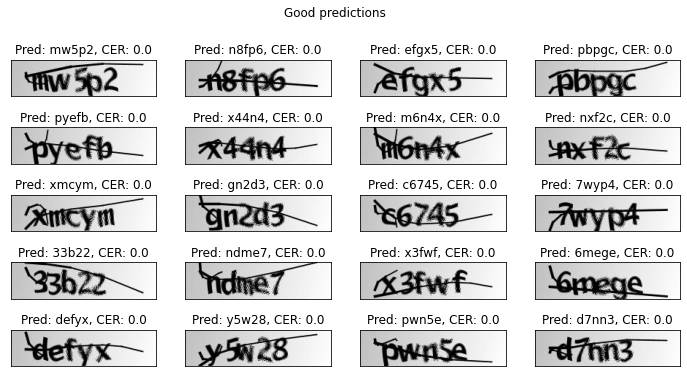

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(12, 6))
fig.suptitle('Good predictions')
axes = axes.flat

for i, (cer, i_img, pred_label) in enumerate(sorted(good_predict, key=lambda x: x[0])[:20]):
    true_label = get_label_from_ids(test_dataset[i_img][1].unsqueeze(0))
    axes[i].imshow(Image.fromarray(test_dataset[i_img][0].numpy().squeeze() * IMAGE_STD + IMAGE_MEAN).convert('L'), cmap='gray')
    axes[i].set_title(f'Pred: {pred_label}, CER: {round(cer.item(), 4)}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

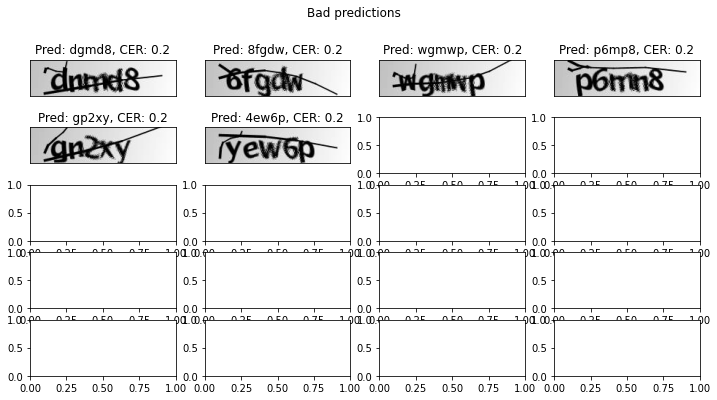

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(12, 6))
fig.suptitle('Bad predictions')
axes = axes.flat

for i, (cer, i_img, pred_label) in enumerate(sorted(bad_predict, key=lambda x: x[0], reverse=True)[:20]):
    true_label = get_label_from_ids(test_dataset[i_img][1].unsqueeze(0))
    axes[i].imshow(Image.fromarray(test_dataset[i_img][0].numpy().squeeze() * IMAGE_STD + IMAGE_MEAN).convert('L'), cmap='gray')
    axes[i].set_title(f'Pred: {pred_label}, CER: {round(cer.item(), 4)}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])